# Graded Challenge 4
## Data
**The data used in this project is the usage behavior summary of approximately 9.000 active credit card holders during the last 6 months. Customer behavior is represented by 18 variables such as the amount of payment done and how frequently the cash in advance is paid.**
## Objective
**Clustering the credit card holders into separate groups based on their behavior in order to effectively tailor the credit card marketing strategy for each group.**

# A. Import Library

In [26]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering as AC
from yellowbrick.cluster import SilhouetteVisualizer
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

SyntaxError: invalid syntax (<ipython-input-26-2565211ebf74>, line 12)

# B. Data Loading

In [2]:
data = pd.read_csv(r"C:\Users\akaza\OneDrive\Documents\Hacktiv8\P1\Graded Challenge 4\CCGENERAL.csv")

df = data.copy()

data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# C. Data Cleaning

### Dropping Irrelevant Data

In [3]:
df = df.drop(['CUST_ID'], axis=1)

**Customer ID is just an identifier for each person, not a behavior variable.**

### Missing Values

In [4]:
data.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

**There appears to be one missing value in CREDIT_LIMIT and 313 missing values in MINIMUM_PAYMENTS.**

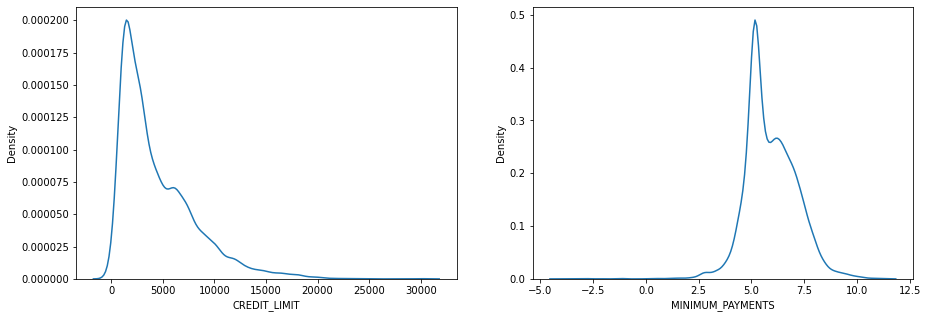

In [5]:
# Check the distribution of the two data.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

sns.kdeplot(data["CREDIT_LIMIT"], ax = ax1)
sns.kdeplot(np.log(data["MINIMUM_PAYMENTS"]), ax = ax2)

plt.show()

**Both CREDIT_LIMIT and MINIMUM_PAYMENTS distributions are skewed, therefore it is appropriate to replace the missing values in those columns with each of its' median value.**

In [6]:
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), axis = 0)
df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].median(), axis = 0)

# D. Data Exploration

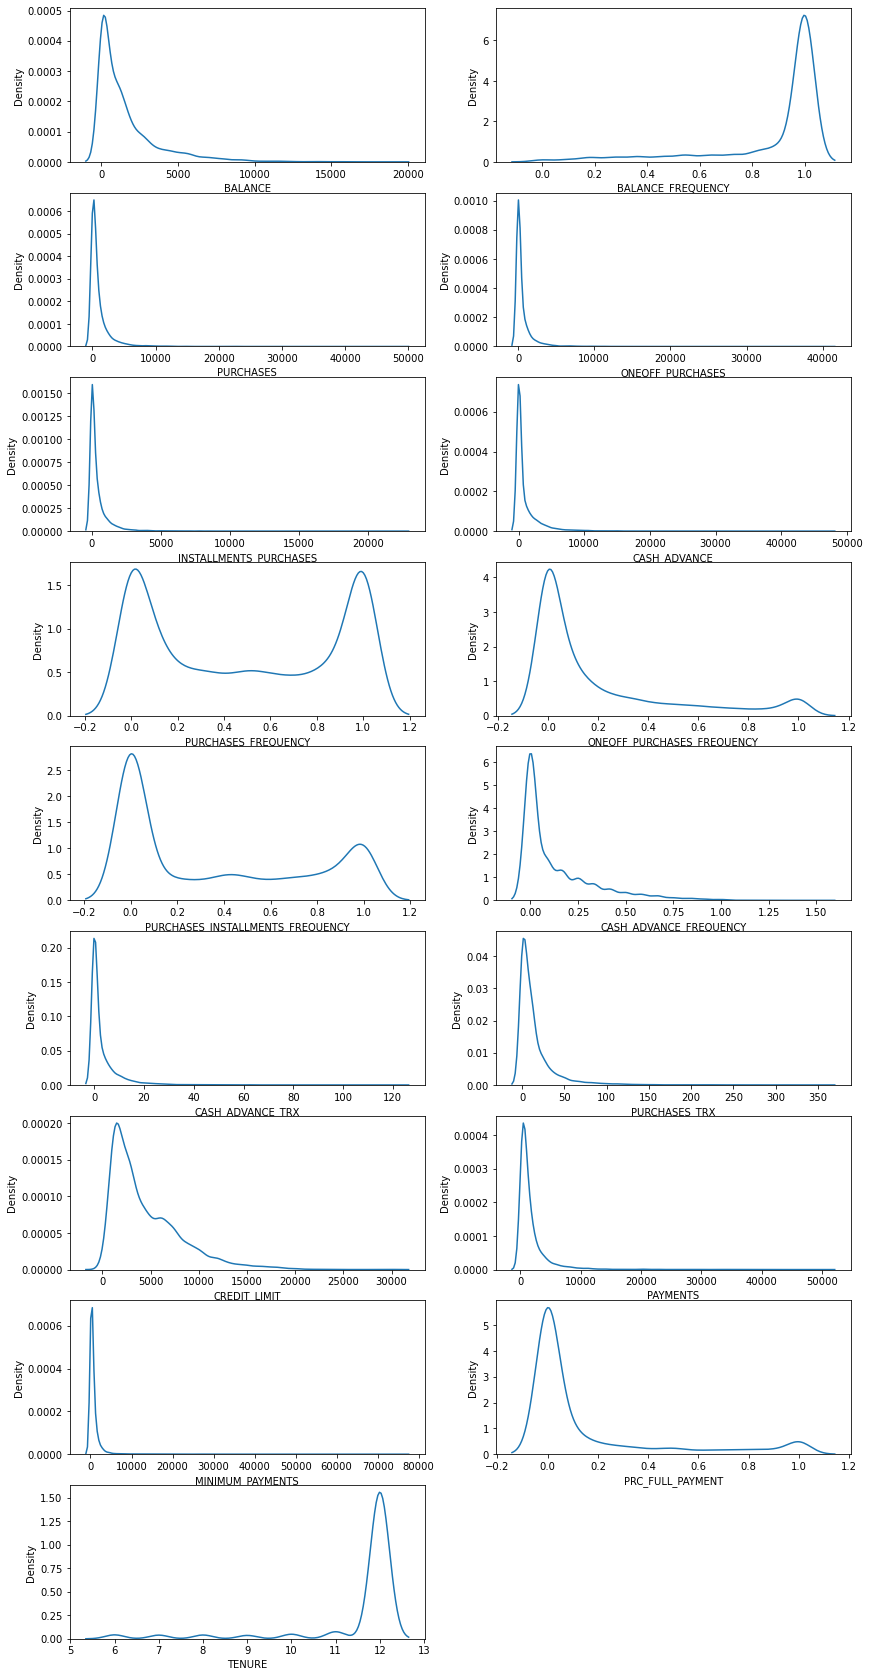

In [7]:
cols = [df.columns]

plt.figure(figsize=(14,30))

for i, col in enumerate(df):
    ax = plt.subplot(9, 2, i+1)
    sns.kdeplot(df[col], ax=ax)
    
plt.show()

* **The distribution density of most the columns are right-skewed.**
* **For example, the BALANCE is right-skewed. This indicates most credit card holders has a balance of around 0 to 5000, while there are some affluent people who has more than that.**
* **The density distribution of PURCHASE_FREQUENCY is interesting because there is spike at the start and end point. This may indicate that people who rarely purchase using their credit card is just as many as people who frequently uses it. While the people who are in between are less than the both them.**
* **The TENURE density seems to converge around 12,which means most of the credit card holders are given 12 months to pay their credit card bills. However, it seems that there are also some holders that are given 6, 7, 8, and so on tenure period.**

### Evaluate Collinearity between Columns

In [8]:
vif = pd.DataFrame()
vif["feature"] = df.columns

vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

vif

,feature,VIF
0,BALANCE,4.108714
1,BALANCE_FREQUENCY,18.108278
2,PURCHASES,58773.751426
3,ONEOFF_PURCHASES,32776.831050
4,INSTALLMENTS_PURCHASES,10399.626093
5,CASH_ADVANCE,3.461101
6,PURCHASES_FREQUENCY,26.445731
7,ONEOFF_PURCHASES_FREQUENCY,5.712731
8,PURCHASES_INSTALLMENTS_FREQUENCY,17.329860
9,CASH_ADVANCE_FREQUENCY,4.913554


**There are 8 columns with a VIF score greater than 5, those columns are highly collinear with the other explanatory variables and therefore redundant. This finding suggest that the dimension of this data can be reduced at the very least to have 10 features/dimensions.**

# E. Data Preprocessing

### Scaling the Data

In [9]:
# The data needs to be scaled for the PCA process.

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

### Dimension Reduction using PCA

In [10]:
# Defining the PCA model to test the optimal n_components
pca_test = PCA(n_components = 10).fit(df_scaled)

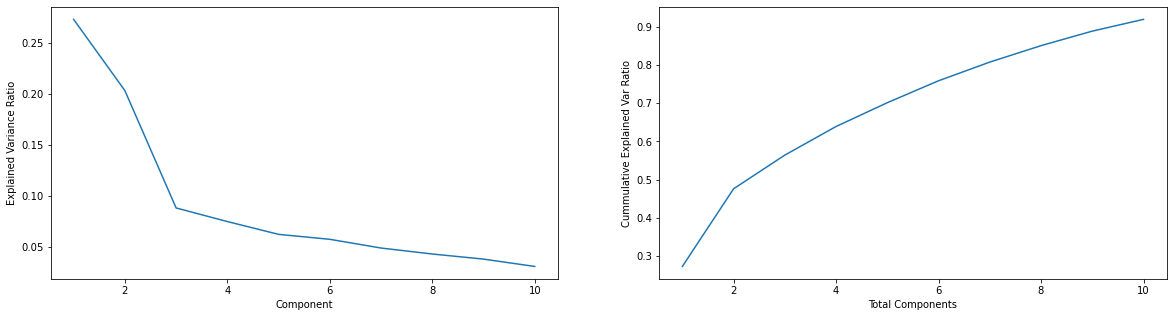

The cumulative EVR for each total components: [0.27297671 0.47611451 0.56424633 0.63904157 0.70128886 0.75868943
 0.80752368 0.85051572 0.8884983  0.91929833]


In [12]:
# Visualization of the effect of each n_components to the Explained Var Ratio

fig,ax = plt.subplots(ncols = 2, figsize=(20,5))
ax[0].plot(range(1,11), pca_test.explained_variance_ratio_)
ax[0].set_xlabel('Component')
ax[0].set_ylabel('Explained Variance Ratio')

ax[1].plot(range(1,11), np.cumsum(pca_test.explained_variance_ratio_))
ax[1].set_xlabel('Total Components')
ax[1].set_ylabel('Cummulative Explained Var Ratio')
plt.show()

cumsum = np.cumsum(pca_test.explained_variance_ratio_)
print("The cumulative EVR for each total components:", cumsum)

* **There is a continuous decrease of EVR with each added component.**
* **There is a significant break at the 3rd component in the EVR graph, however using 3 components only reflected 56.42% of the entire data.**
* **It also appears that there is a slight break at the 7th component, and 7 components represents 80.75% of the data. This is an acceptable level and this value will be used for the next processes.**

In [13]:
# Defining the PCA
pca = PCA(n_components = 7)
pca_data = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame.from_records(data = pca_data, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'])

pca_df.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7
0,-1.683649,-1.072241,0.475660,0.679928,0.043195,0.068069,0.822155
1,-1.134085,2.509150,0.602216,-0.109542,0.662638,-1.102255,-0.384282
2,0.969395,-0.383577,0.090970,1.238359,-2.166584,-0.320185,-1.542496
3,-0.888220,0.004648,1.499800,1.075271,0.225828,-0.171540,-0.236644
4,-1.600021,-0.683795,0.347927,1.013642,-0.453816,0.077004,0.698278


# F. Model Definition and Training

### Determining the Optimal Clusters

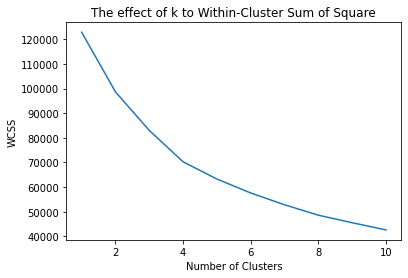

In [16]:
wcss = []

# Iteration to test k-value of 1 to 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 69)
    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The effect of k to Within-Cluster Sum of Square', fontsize = 12)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

**There is a noticeable break in the graph at 4th number of clusters. The elbow method suggest that it is the optimal number of cluster, however further testing is required.**

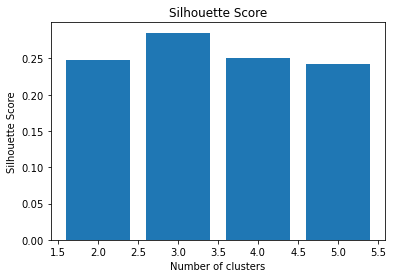

In [19]:
silhouette_scores = [] 

for n_cluster in range(2, 6):
    silhouette_scores.append( 
        silhouette_score(pca_data, KMeans(n_clusters = n_cluster).fit_predict(pca_data))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5] 
plt.bar(k, silhouette_scores)
plt.title('Silhouette Score', fontsize = 12)
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show()

**From the silhouette score, 3 clusters achieved the highest score thus indicating that it is the most optimal number of cluster.**

In [27]:
def plot_silhouette(range_n_clusters,X):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.24798678595511758
For n_clusters = 3 The average silhouette_score is : 0.28347264201366007
For n_clusters = 4 The average silhouette_score is : 0.2516601912372477
For n_clusters = 5 The average silhouette_score is : 0.24063924515563923


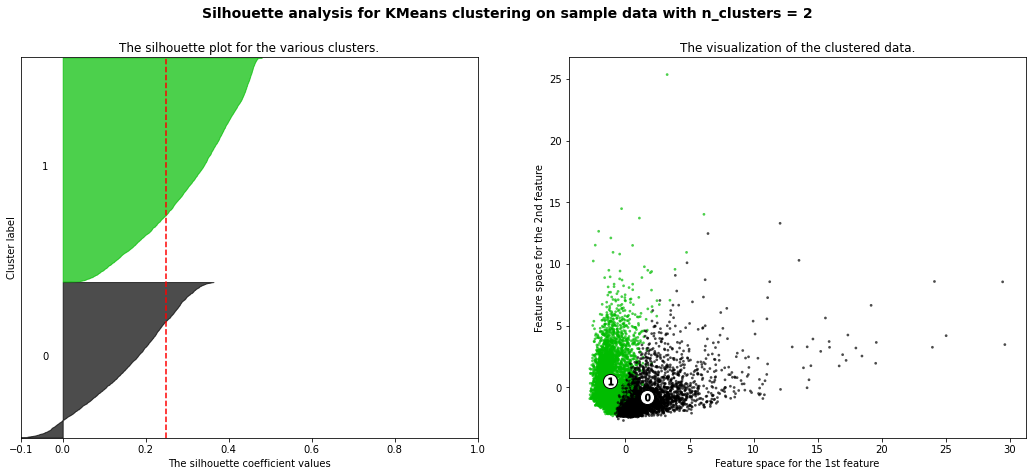

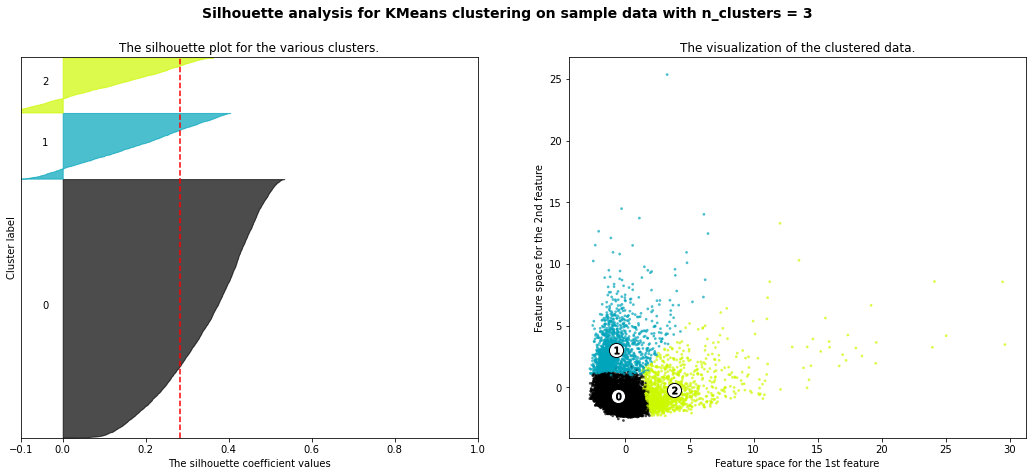

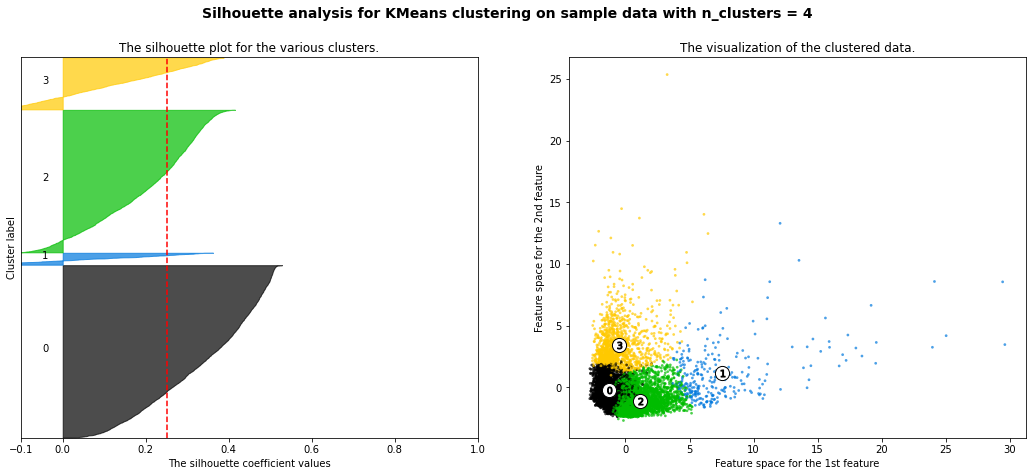

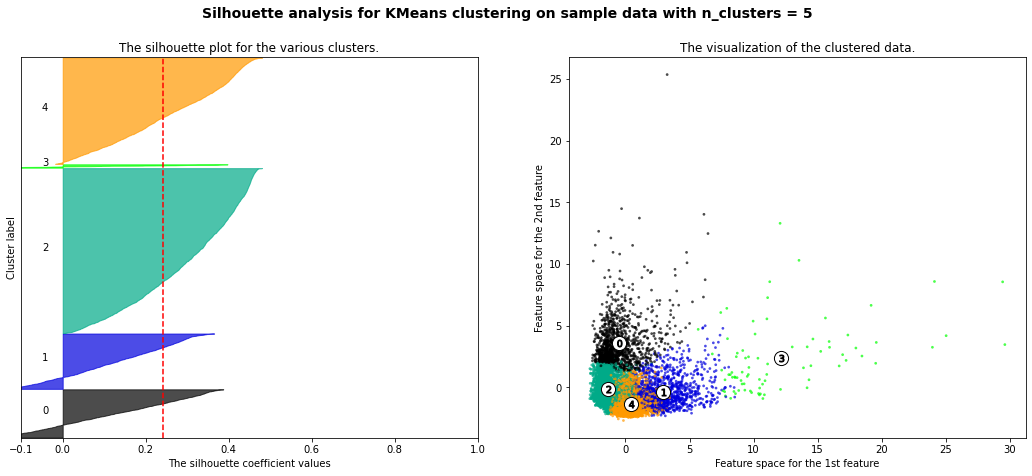

In [28]:
k =[2,3,4,5]
plot_silhouette(k, pca_data)

**From the Silhouette score and graph it is also determined that three is the most optimal number of clusters. Therefore, considering all the previous testing, the clustering model is going to use 3 clusters.**

### Model Definition and Training using the Optimal Number of Clusters

In [29]:
# KMeans
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 69).fit(pca_data)

# Agglomerative Clustering
agg = AC(n_clusters = 3, affinity = 'euclidean', linkage="ward").fit(pca_data)

# G. Model Evaluation

### KMeans

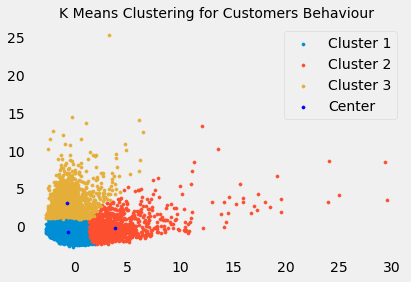

0.2837503954345678

In [37]:
# Visualizing the Clusters

y_pred = kmeans.predict(pca_data)

centers = kmeans.cluster_centers_

plt.style.use('fivethirtyeight')

plt.scatter(pca_data[y_pred == 0, 0], pca_data[y_pred == 0, 1], s = 10, label = 'Cluster 1')
plt.scatter(pca_data[y_pred == 1, 0], pca_data[y_pred == 1, 1], s = 10, label = 'Cluster 2')
plt.scatter(pca_data[y_pred == 2, 0], pca_data[y_pred == 2, 1], s = 10, label = 'Cluster 3')
plt.scatter(centers[:,0], centers[:, 1], s = 10, c = 'blue' , label = 'Center')

plt.style.use('fivethirtyeight')
plt.title('K Means Clustering for Customers Behaviour', fontsize = 14)
plt.legend()
plt.grid()
plt.show()

labels_kmeans = kmeans.labels_

silhouette_score(pca_data, labels_kmeans)

* **From the graph we can see that the model has appopriately clustered the data into three separate groups. No data from one cluster seems to be mixed with data from other clusters.**
* **The silhouette score of this model is 28.37%**

In [47]:
df_kmeans = df.copy()
df_kmeans['Cluster'] = labels_kmeans

df_kmeans.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,2
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12,0
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


In [49]:
df_kmeans['Cluster'].unique()

array([0, 2, 1])

In [52]:
# get a new dataset with each cluster 
df_clust1 = df_kmeans.loc[df_kmeans['Cluster'] == 0]
df_clust2 = df_kmeans.loc[df_kmeans['Cluster'] == 1]
df_clust3 = df_kmeans.loc[df_kmeans['Cluster'] == 2]

#### Cluster 1 Description

In [53]:
df_clust1.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Cluster
count,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6109.0
mean,808.176215,0.834593,489.917630,243.893644,246.345309,338.255299,0.458861,0.129283,0.340464,0.070190,1.245539,8.462924,3256.690716,902.258335,533.060077,0.153662,11.475364,0.0
std,974.002528,0.268466,574.233616,462.268277,386.027515,667.575139,0.379358,0.217831,0.382147,0.108271,2.165005,9.311804,2635.739522,1117.504080,1313.448277,0.289257,1.390723,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,0.019163,0.000000,6.000000,0.0
25%,57.657781,0.727273,52.680000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1500.000000,290.331406,149.982961,0.000000,12.000000,0.0
50%,432.385707,1.000000,298.200000,0.000000,73.800000,0.000000,0.416667,0.000000,0.166667,0.000000,0.000000,6.000000,2500.000000,566.870280,229.740381,0.000000,12.000000,0.0
75%,1247.423771,1.000000,718.010000,295.000000,355.160000,364.974098,0.833333,0.166667,0.666667,0.090909,2.000000,12.000000,4000.000000,1110.870941,481.438547,0.166667,12.000000,0.0
max,8115.039014,1.000000,4562.690000,4562.690000,3200.000000,7894.578816,1.000000,1.000000,1.000000,0.714286,23.000000,111.000000,23000.000000,23150.571840,28483.254830,1.000000,12.000000,0.0


#### Cluster 2 Description

In [54]:
df_clust2.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Cluster
count,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.0
mean,2188.290453,0.981449,4174.191655,2658.046092,1516.611764,434.512105,0.945957,0.657358,0.739615,0.060409,1.375291,55.048174,7663.053613,4039.892672,1224.230709,0.298076,11.916861,1.0
std,2551.091959,0.073371,4212.578621,3573.698870,1837.943267,1277.129948,0.122176,0.317875,0.328597,0.130163,3.740175,42.641376,4338.987929,4702.477197,3620.968537,0.384252,0.553586,0.0
min,12.423203,0.090909,451.010000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,500.000000,0.000000,14.012997,0.000000,6.000000,1.0
25%,359.149336,1.000000,2094.270000,892.695000,455.660000,0.000000,0.916667,0.416667,0.583333,0.000000,0.000000,29.000000,4500.000000,1660.606653,190.169912,0.000000,12.000000,1.0
50%,1210.573775,1.000000,3048.400000,1748.940000,1067.600000,0.000000,1.000000,0.750000,0.916667,0.000000,0.000000,43.000000,7000.000000,2683.090485,373.675969,0.083333,12.000000,1.0
75%,3126.591426,1.000000,4699.065000,3130.205000,1907.315000,116.228610,1.000000,1.000000,1.000000,0.083333,1.000000,67.000000,10000.000000,4591.020352,1054.112156,0.666667,12.000000,1.0
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,19513.474830,1.000000,1.000000,1.000000,1.000000,48.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000,1.0


#### Cluster 3 Description

In [55]:
df_clust3.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Cluster
count,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.0
mean,4020.959713,0.958765,394.846718,251.906615,143.019685,3948.055182,0.236815,0.113377,0.147965,0.452385,12.675676,5.859717,6735.105885,3089.060126,1756.670931,0.034365,11.351351,2.0
std,2689.998247,0.112578,758.393696,575.160054,371.182540,3399.780762,0.331202,0.205154,0.284040,0.220701,11.434647,11.555611,3742.816067,4013.569872,3518.888112,0.100712,1.514506,0.0
min,4.382924,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,16.950090,0.000000,6.000000,2.0
25%,1905.424763,1.000000,0.000000,0.000000,0.000000,1917.463394,0.000000,0.000000,0.000000,0.272727,6.000000,0.000000,4000.000000,942.970990,576.544865,0.000000,12.000000,2.0
50%,3506.080206,1.000000,0.000000,0.000000,0.000000,3181.085174,0.000000,0.000000,0.000000,0.416667,10.000000,0.000000,6000.000000,1678.004930,1095.113264,0.000000,12.000000,2.0
75%,5602.772482,1.000000,472.017500,227.425000,72.435000,4860.760425,0.416667,0.166667,0.166667,0.583333,16.000000,7.000000,9000.000000,3475.838927,1834.765259,0.000000,12.000000,2.0
max,16304.889250,1.000000,7194.530000,6678.260000,3887.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,104.000000,19600.000000,39048.597620,61031.618600,1.000000,12.000000,2.0


### Agglomerative Clustering

0.20164224506223805

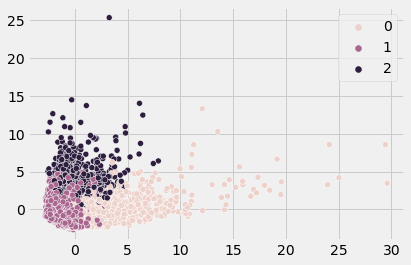

In [42]:
y_agg = agg.fit_predict(pca_data)
agg_labels = agg.labels_

sns.scatterplot(x=pca_data[:,0],y=pca_data[:,1],hue=agg.labels_)

silhouette_score(pca_data, agg_labels)

* **The Agglomerative Clustering model has succesfully clustered the data into three separate groups, however the graph shows that the divisions among the clusters are note very well defined. There are some data mixed in with other clusters.**
* **The model resulted in a silhouette score of 20.16%, which is lower than the previous KMeans model. This may explain the fact that the division among cluster are clearer for the KMeans algorithm.**

In [56]:
df_agg = df.copy()
df_agg['Cluster'] = agg_labels

# get a new dataset with each cluster 
df_clust01 = df_agg.loc[df_agg['Cluster'] == 0]
df_clust02 = df_agg.loc[df_agg['Cluster'] == 1]
df_clust03 = df_agg.loc[df_agg['Cluster'] == 2]

#### Cluster 1 Description

In [57]:
df_clust01.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Cluster
count,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,3277.0
mean,1261.137023,0.939669,2106.534104,1183.963393,922.950171,309.787567,0.898135,0.357978,0.738306,0.051328,1.124199,31.604821,5067.299097,2181.648062,707.807893,0.278065,11.960940,0.0
std,1862.234242,0.158200,3141.183747,2550.068269,1292.779918,977.846826,0.155241,0.377965,0.311571,0.118282,3.081734,33.058313,3867.500014,3333.356129,1393.235339,0.361976,0.250153,0.0
min,0.000000,0.000000,8.400000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,300.000000,0.000000,0.019163,0.000000,6.000000,0.0
25%,100.418706,1.000000,518.880000,0.000000,262.710000,0.000000,0.833333,0.000000,0.583333,0.000000,0.000000,12.000000,2000.000000,578.819329,169.703195,0.000000,12.000000,0.0
50%,507.144348,1.000000,1201.970000,344.910000,550.000000,0.000000,1.000000,0.250000,0.833333,0.000000,0.000000,21.000000,4000.000000,1261.113010,221.961649,0.083333,12.000000,0.0
75%,1654.795346,1.000000,2505.300000,1398.570000,1130.010000,0.000000,1.000000,0.666667,1.000000,0.000000,0.000000,38.000000,7000.000000,2507.704747,705.863650,0.545455,12.000000,0.0
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,19513.474830,1.000000,1.000000,1.000000,1.000000,48.000000,358.000000,30000.000000,50721.483360,22011.779800,1.000000,12.000000,0.0


#### Cluster 2 Description

In [58]:
df_clust02.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Cluster
count,4235.000000,4235.000000,4235.000000,4235.000000,4235.000000,4235.000000,4235.000000,4235.000000,4235.000000,4235.000000,4235.000000,4235.000000,4235.000000,4235.000000,4235.000000,4235.000000,4235.000000,4235.0
mean,888.143182,0.792655,338.824349,237.113566,102.027542,639.876366,0.260957,0.108145,0.150459,0.108720,1.996930,4.368123,3206.620777,968.218552,420.706753,0.100251,11.056907,1.0
std,1004.575683,0.289565,523.168677,482.649341,216.419557,1251.647351,0.288794,0.178183,0.248680,0.151540,3.370976,6.243771,2681.292725,1800.151571,576.343680,0.238380,1.795476,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,0.037744,0.000000,6.000000,1.0
25%,69.402348,0.636364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1500.000000,257.148759,142.246256,0.000000,11.000000,1.0
50%,603.628060,1.000000,129.000000,0.000000,0.000000,46.656862,0.166667,0.000000,0.000000,0.083333,1.000000,2.000000,2500.000000,509.404913,270.736901,0.000000,12.000000,1.0
75%,1373.213798,1.000000,450.000000,250.000000,111.340000,867.261130,0.416667,0.166667,0.250000,0.166667,3.000000,6.000000,4000.000000,991.849391,478.546691,0.083333,12.000000,1.0
max,9601.071318,1.000000,6520.000000,6520.000000,2068.150000,14371.787890,1.000000,1.000000,1.000000,1.166667,48.000000,98.000000,23000.000000,34107.074990,10057.561920,1.000000,12.000000,1.0


#### Cluster 3 Description

In [59]:
df_clust03.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Cluster
count,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.0
mean,4247.578100,0.984273,445.514520,290.883505,154.701718,3501.979270,0.236645,0.125806,0.142621,0.403972,11.777469,6.665508,6980.702364,2963.818644,2406.631429,0.027793,11.862309,2.0
std,2709.467857,0.062998,860.880835,621.358174,447.435959,3586.578588,0.322288,0.218641,0.277996,0.243825,12.133415,14.520547,3917.546311,3690.256685,5046.984758,0.084334,0.566237,0.0
min,0.488050,0.363636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,18.219526,0.000000,6.000000,2.0
25%,2122.111933,1.000000,0.000000,0.000000,0.000000,1298.586615,0.000000,0.000000,0.000000,0.250000,4.000000,0.000000,4000.000000,1012.753227,698.866143,0.000000,12.000000,2.0
50%,3839.409308,1.000000,40.000000,0.000000,0.000000,2699.343869,0.083333,0.000000,0.000000,0.416667,9.000000,1.000000,6500.000000,1719.772744,1268.607345,0.000000,12.000000,2.0
75%,5821.903668,1.000000,503.350000,303.950000,74.347500,4504.933821,0.416667,0.166667,0.166667,0.583333,15.000000,7.000000,9500.000000,3338.121087,2093.959516,0.000000,12.000000,2.0
max,16304.889250,1.000000,7739.480000,6678.260000,7739.480000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,162.000000,21500.000000,39048.597620,76406.207520,0.916667,12.000000,2.0


# H. Model Inference

### Create New Random Data


In [76]:
df_test = df.sample()

df_test

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
7231,3840.50578,1.0,0.0,0.0,0.0,5558.961557,0.0,0.0,0.0,0.5,20,0,5500.0,4608.621771,904.882748,0.0,12


In [75]:
df_test_scaled = scaler.fit_transform(df_test)

df_test_pca = pca.transform(df_test_scaled)

kmeans.predict(df_test_pca)

# I. Conclusion and Analysis

* **This project determined that the optimal n_components used for the PCA is 7. In other words, the original 17 dimensional data is reduced into a 7 dimensional data.**
* **It is determined that three is the most optimal number of cluster in order to get the highest silhouette score.**
* **The KMeans Clustering algorithm succesfully separated the data into 3 clusters with a silhouette score of 28.37%.**
* **The Agglomerative Clustering algorithm succesfully separated the data into 3 clusters with a silhouette score of 20.16%.**
* **Based on both the visualization of the algorithm result and each of its silhouette score, the KMeans model is determined to be the better choice for the clustering.**

